In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

name_of_file = 'PD110_time_no_empty'                                          # Основной с распределенными столкновениями, время - прямое
# name_of_file = 'PD114_time_inv_0coord'                                      # Основной столкновния в нуле, время - обратное 

number_of_groups = 4                # Количество интервалов на которые делятся прицельные параметры
number_of_epoches_lin = 100        # Количество эпох в обучении полносвязной нейросети
number_of_epoches_conv = 100        # Количество эпох в обучении сверточной нейросети
batch_size = 800                    # Размер батча
training_set_part = 0.8             # Часть от 0 до 1 выделяемая на тренировочный набор


norms = [200, 32, 6]

input_data = []

with open('data/' + name_of_file + '.dat', 'r') as inpf: 
    l = inpf.readline()
    s = l.strip().split()

    # Чтение максимального количества данных в строке и количества строк для одного события
    maximum_hits = int(s[2])
    n_lines = int(s[4])
    number_of_features = n_lines * maximum_hits
    print(l)

    amount = 0
    for line in inpf:
        if True:
            features = []
            s = line.strip().split()
            b = float(s[0])
            coord = float(s[1])
            phi_b = float(s[2])

            n = 0
            for digit in s[3:]:  
                if n < maximum_hits:
                    features.append(float(digit) / norms[0])
                elif n < maximum_hits * 2:
                    features.append(float(digit) / norms[1])
                elif n < maximum_hits * 3:
                    features.append(float(digit) / norms[2])
                elif n < maximum_hits * 4:
                    features.append(float(digit) / norms[3])
                else:
                    features.append(float(digit) / norms[4])
                      
                n += 1

            input_data.append([b, coord, features])
            amount += 1
        

cuda:0
Maximum hits: 60 Lines: 3



In [4]:
class DatasetNN_augm(torch.utils.data.Dataset):
    def __init__(self, labels, features):
        self.labels = labels
        self.features = features

    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        time_part = self.features[idx][0:maximum_hits].to('cpu')
        cell_part = self.features[idx][maximum_hits:2*maximum_hits].to('cpu')
        det_part = self.features[idx][2*maximum_hits:].to('cpu')

        cell_part = (cell_part * norms[1]).type(torch.IntTensor)
        # cell_angle = ( cell_part - 1 ) % 8
        # cell_rad = (cell_part - 1 ) // 8

        cell_angle = cell_part % 8
        cell_rad = cell_part // 8

        nonzero = torch.count_nonzero(time_part)
        randomizer = int(7 * np.random.random_sample() + 1)
        new_cell = torch.zeros_like(cell_angle, dtype=torch.float32)


        for n in range(nonzero):
            # new_cell[n] = (cell_rad[n] * 8 + (cell_angle[n] + randomizer) % 8 + 1) / norm_2
            new_cell[n] = (cell_rad[n] * 8 + (cell_angle[n] + randomizer) % 8) / norm_2

        new_features = torch.cat([time_part, new_cell, det_part]).to(device)   
        

        label = self.labels[idx]
        feature = self.features[idx]
        
        sample = {'label': label, 'feature': feature,  'augm_feature': new_features}

        return sample

# Создание класса для набора данных с двумя функциями
class DatasetNN(torch.utils.data.Dataset):
    def __init__(self, labels, features):           # В этом методе создаются две переменные для характеристик и для меток
        self.labels = labels
        self.features = features

    def __len__(self):                       # Эта функция должна возвращать размер набора данных
        return self.labels.shape[0]

    def __getitem__(self, idx):              # Эта функция возвращает один (или несколько, зависит от размерности переменной idx) из примеров данных с индексом idx
        if torch.is_tensor(idx):             # Если набор индексов задан как тензор, то приведение его к виду списка       
            idx = idx.tolist()

        label = self.labels[idx]
        feature = self.features[idx]

        sample = {'label': label, 'feature': feature}   # Возвращает пример (набор примеров) в виде словаря (пара метка-характеристика)

        return sample



# Encode labels into segments with equal length
def encode_equi_segment(b: float, maximum: float, groups: int) -> int:
    if b == maximum:
        return groups - 1
    else:
        length_of_segment = maximum / groups
        return int( b // length_of_segment )

    
# Encode labels into segments with equal size
def encode_equi_size(labels_arr: np.ndarray, groups: int ) -> np.ndarray:
    lb_sorted = np.sort(labels_arr, axis=0)
    segment = lb_sorted.shape[0]//groups
    print("Length of segment: {}".format(segment))
    borders = []
    
    # define borders of segments
    for i in range(groups):   
        if i != (groups - 1) and i != 0:
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[(i+1)*segment].item()))
        elif i == 0:
            borders.append((0, lb_sorted[(i+1)*segment].item()))
        else: 
            borders.append((lb_sorted[(i)*segment].item(), lb_sorted[labels.shape[0] - 1].item()))
    print("Encoded into intervals: {}" .format(borders))
    lb_enc = np.zeros_like(labels, dtype=int)
    incr = 0
    
    # iterate over all (not sorted) labels and encode them
    for elem in labels:   
        gr = 0
        for seg in borders:
            if seg[0] < elem <= seg[1]:
                lb_enc[incr] = gr
                break
            gr += 1
        incr += 1
    return lb_enc


def get_correct_predictions(preds: torch.Tensor, values: torch.Tensor) -> int:
    return preds.argmax(dim=1).eq(values).sum().item()


def encode_binary(labels_arr: np.ndarray, border: float) -> np.ndarray:
    result_arr = np.zeros_like(labels_arr)
    for ind in range(len(labels_arr)):
        if labels_arr[ind] > border:
            result_arr[ind] = 1
    return result_arr



np.random.shuffle(input_data)
input_sorted = sorted(input_data, key=lambda x: (x[0]))
    
features = np.zeros((len(input_data), number_of_features))
labels = np.zeros((len(input_data), 1))
coordinates = np.zeros((len(input_data), 1))
incr = 0
for elem in input_data:
    labels[incr] = np.array(elem[0])
    coordinates[incr] = np.array(elem[1])
    features[incr] = np.array(elem[2])
    incr += 1
    

# Divide into test and training sets

size_of_training_set = int(features.shape[0] * training_set_part)
size_of_test_set = features.shape[0] - size_of_training_set

# Divide labes into test and training sets
print("Были прицельные параметры: \n {}".format(labels[:6]))

labels_encoded_equisized = encode_equi_size(labels, number_of_groups)
print("Закодированы в интервалы: \n {}".format(labels_encoded_equisized[:6]))

train_labels = torch.flatten(torch.tensor(labels_encoded_equisized[:size_of_training_set])).to(device)
test_labels = (torch.flatten(torch.tensor(labels_encoded_equisized[size_of_training_set:]))).type(torch.LongTensor).to(device)



train_coordinates = torch.flatten(torch.tensor(coordinates[:size_of_training_set])).to(device)
test_coordinates = torch.flatten(torch.tensor(coordinates[size_of_training_set:])).to(device)

train_features = torch.tensor(features[:size_of_training_set], dtype=torch.float32).to(device)
test_features = torch.tensor(features[size_of_training_set:], dtype=torch.float32).to(device)

print('Train shape: {}'.format(train_features.shape))
print('Test shape: {}'.format(test_features.shape))

Были прицельные параметры: 
 [[ 9.198]
 [ 9.357]
 [ 7.225]
 [13.782]
 [ 9.056]
 [13.303]]
Length of segment: 51387
Encoded into intervals: [(0, 6.736), (6.736, 9.494), (9.494, 11.621), (11.621, 16.114)]
Закодированы в интервалы: 
 [[1]
 [1]
 [1]
 [3]
 [1]
 [3]]
Train shape: torch.Size([164440, 180])
Test shape: torch.Size([41111, 180])


In [5]:
# Linear Fully connected network. 
# Convolutional - three blocks below

class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.lin1 = nn.Linear(in_features = number_of_features, out_features = 256)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features = self.lin1.out_features, out_features = 128)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)
        
        self.lin3 = nn.Linear(in_features = self.lin2.out_features, out_features = 64)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02) # было 3
        
        self.lin4 = nn.Linear(in_features = self.lin3.out_features, out_features = 32)
        nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02)
        
        # self.lin5 = nn.Linear(in_features = 32, out_features = 16)
        # nn.init.normal_(self.lin5.weight, mean=0.0, std=0.02)
        
        # self.lin6 = nn.Linear(in_features = 16, out_features = 8)
        # nn.init.normal_(self.lin6.weight, mean=0.0, std=0.02)
        
        self.out = nn.Linear(in_features = self.lin4.out_features, out_features = number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        # print(self.lin1.weight[:4, :8])
        # print(self.lin2.weight[:4, :8])
        # print(self.lin3.weight[:4, :8])
        # print(self.out.weight)
        
    def forward(self, t):
        t = t
        t = F.relu(self.lin1(t))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        t = F.relu(self.lin4(t))
        # t = F.relu(self.lin5(t))
        # t = F.relu(self.lin6(t))
        t = F.softmax(self.out(t), dim=1)
        return t


In [6]:
# В этом блоке - сам процесс обучения
trDS = DatasetNN(train_labels, train_features)
teDS = DatasetNN(test_labels, test_features)
# trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)
teDL = torch.utils.data.DataLoader(trDS, batch_size=len(teDS))

divisors = [400, 800, 1200, 1600, 2220, 3700, 5550, 8880, 14800, 29600]                              # для 177600
# divisors = [320, 550, 704, 880, 1600, 1760, 2200, 3520, 4400, 8800]                                # для 17600
# divisors = [320, 400, 600, 800, 1600, 4000, 8000, 12000, 16000, 24000]                                 # для 48000

net = Network().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

loss_weights = torch.ones(number_of_groups).to(device)

total_loss = []
total_accuracy = []
total_val_loss = []
total_val_accuracy = []

# Learning process
for epoch in range(number_of_epoches_lin):
    total_correct = 0
    t_loss = 0
    idx = int(epoch * 10 / number_of_epoches_lin)
    batch_size = divisors[idx]
    trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)

    for batch in trDL:
        batch_labels = (batch['label']).type(torch.LongTensor).to(device)
        batch_features = batch['feature'].to(device)
        # print(batch_labels)
        # print(batch_labels.shape)

        predicted = net(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        t_loss += (loss.item() * batch_size/len(trDS))
        total_correct += get_correct_predictions(predicted, batch_labels)

    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
        .format(epoch, t_loss, total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss.append(t_loss)
        total_accuracy.append(total_correct*100/train_features.shape[0])
        
        test_preds = net(test_features)
        total_val_loss.append(F.cross_entropy(test_preds, test_labels, loss_weights).item())
        total_val_accuracy.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Epoch:    0 |---> loss is 1.2102466568, total correct predictions: 80734, its 49.096%
Epoch:    1 |---> loss is 1.1684083208, total correct predictions: 87937, its 53.477%
Epoch:    2 |---> loss is 1.1653119466, total correct predictions: 88608, its 53.885%
Epoch:    3 |---> loss is 1.1643864609, total correct predictions: 89342, its 54.331%
Epoch:    4 |---> loss is 1.1580192350, total correct predictions: 92786, its 56.425%
Epoch:    5 |---> loss is 1.1512280079, total correct predictions: 94553, its 57.500%
Epoch:    6 |---> loss is 1.1486343255, total correct predictions: 95036, its 57.794%
Epoch:    7 |---> loss is 1.1463033480, total correct predictions: 95505, its 58.079%
Epoch:    8 |---> loss is 1.1439106471, total correct predictions: 95810, its 58.264%
Epoch:    9 |---> loss is 1.1414344738, total correct predictions: 96241, its 58.527%
Epoch:   10 |---> loss is 1.1369504380, total correct predictions: 97214, its 59.118%
Epoch:   11 |---> loss is 1.1355910386, total correct 

Test accuracy is 60.23%


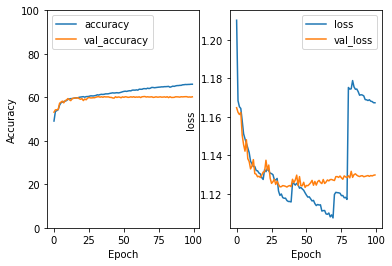

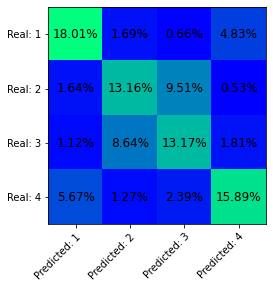

In [7]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy, label='accuracy')
    plt.plot(total_val_accuracy, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss, label='loss')
    plt.plot(total_val_loss, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions = net(test_features)
    test_correct_predictions = get_correct_predictions(test_predictions, test_labels)
    test_accuracy = test_correct_predictions * 100 /test_features.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy))
    
    with open('some_results.txt', 'a') as batch_results:
        batch_results.write('{}  lin: | {:7d}     | {:7d}     | {:7.2f}  |'.format(name_of_file, batch_size, number_of_epoches_conv, test_accuracy))
    
    # Creating of confusion matrix
    stacked = torch.stack((test_labels, test_predictions.argmax(dim=1)), dim=1)
    # horizontal axis - predicted, vertical - true
    confusion_matrix = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    for row in stacked:
       confusion_matrix[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    # print(confusion_matrix)
    # print(400 - torch.count_nonzero(test_labels_tensor).item())
    
    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix[i][j].item()*100/test_features.shape[0], 2)) + '%', ha="center", va="center", size=12)


In [8]:
# Convolutional NN
class NetworkConv(nn.Module):
    def __init__(self):
        super(NetworkConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(n_lines, 6), stride=(1, 2))
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=(n_lines, 40), stride=(1, 40))
        nn.init.normal_(self.conv1.weight, mean=0.0, std=0.02)
        
        self.maxpool1d = nn.MaxPool1d(2, stride=2)

        self.conv_outp_features = int((maximum_hits)/2 - 2)

        # self.lin1 = nn.Linear(in_features=n_detectors*2*5*3, out_features=60)
        self.lin1 = nn.Linear(in_features=self.conv1.out_channels*(int(self.conv_outp_features )), out_features=128)
        nn.init.normal_(self.lin1.weight, mean=0.0, std=0.02)
        
        self.lin2 = nn.Linear(in_features=self.lin1.out_features, out_features=64)
        nn.init.normal_(self.lin2.weight, mean=0.0, std=0.02)

        self.lin3 = nn.Linear(in_features=self.lin2.out_features, out_features=32)
        nn.init.normal_(self.lin3.weight, mean=0.0, std=0.02)
        
        # self.lin4 = nn.Linear(in_features=self.lin3.out_features, out_features=32)
        # nn.init.normal_(self.lin4.weight, mean=0.0, std=0.02) 

        self.out = nn.Linear(in_features=self.lin3.out_features, out_features=number_of_groups)
        nn.init.normal_(self.out.weight, mean=0.0, std=0.02)
        
    def forward(self, t):
        t = torch.reshape(t, (-1, 1, n_lines, maximum_hits))
        t = F.relu(self.conv1(t))
        
        # t = F.relu(self.conv2(t))
        t = torch.reshape(t, (-1, self.conv1.out_channels, self.conv_outp_features))
        # t = self.maxpool1d(t)
        
        t = F.relu(self.lin1(t.reshape(-1, int(self.conv1.out_channels * self.conv_outp_features ))))
        # t = F.relu(self.lin1(t.reshape(-1, 14*16)))
        t = F.relu(self.lin2(t))
        t = F.relu(self.lin3(t))
        # t = F.relu(self.lin4(t))
        
        t = F.softmax(self.out(t), dim=1)
        return t


In [9]:
# В этом блоке - сам процесс обучения
net_c = NetworkConv().to(device)
optimizer_c = optim.Adam(net_c.parameters(), lr=0.001, weight_decay=0.0001)

# Here define weights for loss contribution of segments
loss_weights_c = torch.ones(number_of_groups).to(device)

total_loss_c = []
total_accuracy_c = []
total_val_loss_c = []
total_val_accuracy_c = []

# Learning process
for epoch in range(number_of_epoches_conv):
    total_correct = 0
    t_loss = 0.0

    # batch_size = int(  (len(trDS) / 400) * (int(epoch * 20 / number_of_epoches_conv) + 1)  )                                               # Размер батча от 444*1 до 444*20 = 8800
    
    idx = int(epoch * 10 / number_of_epoches_lin)
    batch_size = divisors[idx]
    trDL = torch.utils.data.DataLoader(trDS, batch_size=batch_size, shuffle=True)

    for batch in trDL:
        batch_labels = batch['label'].type(torch.LongTensor).to(device)
        batch_features = batch['feature'].to(device)

        predicted = net_c(batch_features)
        loss = F.cross_entropy(predicted, batch_labels, loss_weights_c)
        optimizer_c.zero_grad()
        loss.backward()
        optimizer_c.step()
        t_loss += (loss.item() * batch_size / len(trDS))
        # t_loss += (loss.item() / batch_size) / len(trDS)
        total_correct += get_correct_predictions(predicted, batch_labels)
    
    print("Epoch: {:4d} |---> loss is {:4.10f}, total correct predictions: {:5d}, its {:.3f}%"
      .format(epoch, t_loss, total_correct, total_correct*100/train_features.shape[0]))
    
    with torch.no_grad():  # record loss and accuracy info for plots
        total_loss_c.append(t_loss)
        total_accuracy_c.append(total_correct*100/train_features.shape[0])
        
        test_preds = net_c(test_features)
        total_val_loss_c.append(F.cross_entropy(test_preds, test_labels, loss_weights_c).item())
        total_val_accuracy_c.append(get_correct_predictions(test_preds, test_labels)*100/test_features.shape[0])

Epoch:    0 |---> loss is 1.2284017578, total correct predictions: 78229, its 47.573%
Epoch:    1 |---> loss is 1.1812581554, total correct predictions: 86596, its 52.661%
Epoch:    2 |---> loss is 1.1701705072, total correct predictions: 89575, its 54.473%
Epoch:    3 |---> loss is 1.1603609140, total correct predictions: 92390, its 56.185%
Epoch:    4 |---> loss is 1.1582223269, total correct predictions: 93066, its 56.596%
Epoch:    5 |---> loss is 1.1547149521, total correct predictions: 93538, its 56.883%
Epoch:    6 |---> loss is 1.1533563870, total correct predictions: 93865, its 57.082%
Epoch:    7 |---> loss is 1.1519668048, total correct predictions: 94095, its 57.221%
Epoch:    8 |---> loss is 1.1505158998, total correct predictions: 94362, its 57.384%
Epoch:    9 |---> loss is 1.1487634754, total correct predictions: 94725, its 57.605%
Epoch:   10 |---> loss is 1.1462218899, total correct predictions: 95321, its 57.967%
Epoch:   11 |---> loss is 1.1455759861, total correct 

Test accuracy is 61.17%


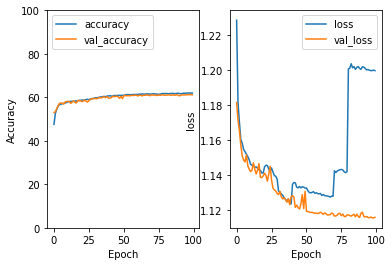

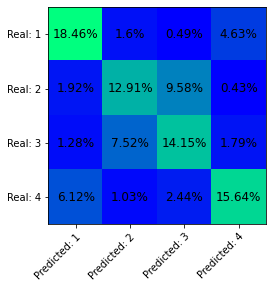

In [10]:
# Graphs and evaluation
with torch.no_grad():
    plt.subplot(1,2,1)
    plt.plot(total_accuracy_c, label='accuracy')
    plt.plot(total_val_accuracy_c, label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 100])
    plt.legend(loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(total_loss_c, label='loss')
    plt.plot(total_val_loss_c, label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    
    
    test_predictions_c = net_c(test_features)
    test_correct_predictions_c = get_correct_predictions(test_predictions_c, test_labels)
    test_accuracy_c = test_correct_predictions_c * 100 /test_features.shape[0]
    print("Test accuracy is {:2.2f}%" .format(test_accuracy_c))
    
    with open('some_results.txt', 'a') as batch_results:
        batch_results.write('          conv: | {:7d}     | {:7d}     | {:7.2f}  |\n'.format(batch_size, number_of_epoches_conv, test_accuracy_c))

    # Creating of confusion matrix
    stacked_c = torch.stack((test_labels, test_predictions_c.argmax(dim=1)), dim=1)
    confusion_matrix_c = torch.zeros((number_of_groups,number_of_groups), dtype=torch.int32)      
    # horizontal axis - predicted, vertical - true
    for row in stacked_c:
        confusion_matrix_c[row[0].item()][row[1].item()] += 1     # row is target, column - predicted
    

    fig, ax = plt.subplots()
    im = ax.imshow(confusion_matrix_c, cmap='winter')
    
    ax.set_xticks(np.arange(confusion_matrix_c.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix_c.shape[1]))
    x_labels = []
    y_labels = []
    for i in range(confusion_matrix_c.shape[0]):
        x_labels.append('Predicted: '+ str(i + 1))
        y_labels.append('Real: ' + str(i + 1))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    for i in range(confusion_matrix_c.shape[0]):
        for j in range(confusion_matrix_c.shape[1]):
            text = ax.text(j, i, str(round(confusion_matrix_c[i][j].item()*100/test_features.shape[0],2)) + '%', ha="center", va="center", size=12)

In [11]:
# Оценка времени работы
testdev = 'cpu' 
nettest = Network().to(device=testdev)

s = len(train_features)
time_test_features = train_features[:s].to(device=testdev)
start_time = time.time()
res = nettest(time_test_features)
res_time = time.time() - start_time
print("Time taken: {} s, for {} events".format(res_time, s))
print("It's {} s per event".format(res_time/s))

Time taken: 0.3820960521697998 s, for 164440 events
It's 2.3236198745426893e-06 s per event
